# Recognition Parametrized Model (RPM): Peer Supervision


Observations $\mathcal{X} = \{ x_j \}$ are groups of MNIST images representing $J$ different renderings of the same digit. The RPM to extract this information without explicit label information - a setting that might be termed "peer-supervision". The model writes:

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j} \left( \mathsf{p_{0,j}}(\mathsf{x_{j}}) \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \right) $$

## Load and Rearanged MNIST

In [1]:
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from utils_process import plot_loss

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils_demo import rearrange_mnist

from fast_rpm import RPM
import torch.nn.functional as F


data_folder = './../MNIST'

# Load MNIST
train_data = datasets.MNIST(
    root=data_folder,
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root=data_folder,
    train=False,
    transform=ToTensor()
)

# Random seeds
torch.manual_seed(2)

# Number of Conditionally independent Factors
num_factors = 2

# Sub-Sample original dataset
train_length = 60000

# Keep Only some digits (for efficiency)
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#sub_ids = torch.tensor([0, 1, 2, 3, 4])
num_digits = len(sub_ids)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations, train_images, train_labels = rearrange_mnist(
    train_data.train_data, 
    train_data.train_labels, 
    num_factors, 
    train_length=train_length,
    sub_ids=sub_ids
)


# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations_test, test_images, test_labels = rearrange_mnist(
    test_data.test_data, 
    test_data.test_labels, 
    num_factors, 
    train_length=test_data.test_labels.shape[0],
    sub_ids=sub_ids
)
test_labels = test_labels.reshape(observations_test[0].shape[0], num_factors)
            

/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")



## Typical Observations

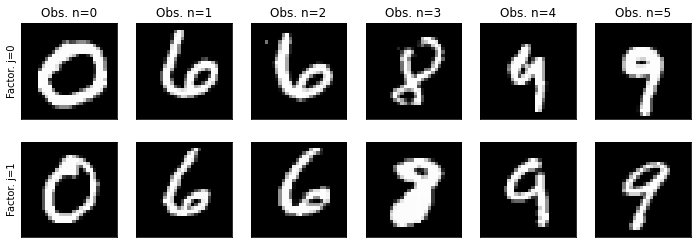

In [2]:
num_plot = np.arange(6)
plt.figure(figsize=(len(num_plot)*2, num_factors*2))
for obsi in range(len(num_plot)):
    for facti in range(num_factors):
        plt.subplot(num_factors, len(num_plot), (1+obsi) + facti * len(num_plot))
        plt.imshow(observations[facti][num_plot[obsi], :, :], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if facti == 0:
            plt.title('Obs. n=' + str(obsi))
        if obsi == 0:
            plt.ylabel('Factor. j=' + str(facti))

## Fit

In [3]:
# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

# Training Move to GPU
obs = [(obsi / obsi.max()).to(device) for obsi in observations]

# Testing Move to GPU
obs_test = [(obsi / obsi.max()).to(device) for obsi in observations_test]

In [4]:
obs[1] += 2 * torch.rand(obs[1].shape, device=device)
obs_test[1] += 2 * torch.rand(obs_test[1].shape, device=device)


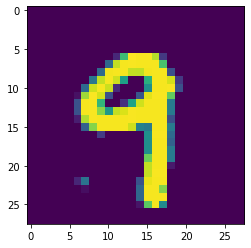

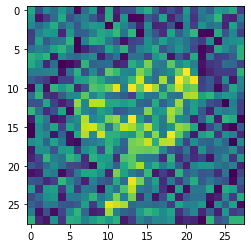

In [5]:
nn = 90
oplot = obs 

plt.figure()
plt.imshow(oplot[0][nn].to("cpu"))

plt.figure()
plt.imshow(oplot[1][nn].to("cpu"))

In [6]:
# Fit params

factors_params = {
    'channels': [[1, 10, 20], [1, 10, 20]],
    'kernel_conv': [[5, 5], [5, 5]],
    'kernel_pool': [[2, 2], [2, 2]],
    'dim_hidden': [[50], [50]],
    'nonlinearity': [F.relu, F.relu],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

fit_params = {
    'num_epoch': 200,
    'batch_size': 2000,
    'dim_latent': 3,
    'factors_params': factors_params,
    'pct': 0.01
}

rpm = RPM(
    observations=obs,
    fit_params=fit_params,
)


RPM on GPU Observations on cuda:0


In [7]:
rpm.precision_chol_vec_factors

tensor([[ 0.6528,  0.9820,  0.4649,  0.2431, -1.2830,  1.0282],
        [-1.3750,  0.4308, -0.7916,  0.3521, -0.2598,  1.4095]],
       device='cuda:0', requires_grad=True)

In [8]:
rpm.precision_chol_vec_factors

tensor([[ 0.6528,  0.9820,  0.4649,  0.2431, -1.2830,  1.0282],
        [-1.3750,  0.4308, -0.7916,  0.3521, -0.2598,  1.4095]],
       device='cuda:0', requires_grad=True)

In [9]:
rpm.fit(obs)

Epoch 2/200 Loss: 2.351689e+01
Epoch 4/200 Loss: 2.258906e+01
Epoch 6/200 Loss: 2.156973e+01
Epoch 8/200 Loss: 2.096064e+01
Epoch 10/200 Loss: 2.066924e+01
Epoch 12/200 Loss: 2.043255e+01
Epoch 14/200 Loss: 2.020748e+01
Epoch 16/200 Loss: 1.999582e+01
Epoch 18/200 Loss: 1.978833e+01
Epoch 20/200 Loss: 1.959644e+01
Epoch 22/200 Loss: 1.940057e+01
Epoch 24/200 Loss: 1.920807e+01
Epoch 26/200 Loss: 1.901818e+01
Epoch 28/200 Loss: 1.882672e+01
Epoch 30/200 Loss: 1.863995e+01
Epoch 32/200 Loss: 1.845834e+01
Epoch 34/200 Loss: 1.828071e+01
Epoch 36/200 Loss: 1.810971e+01
Epoch 38/200 Loss: 1.794031e+01
Epoch 40/200 Loss: 1.777532e+01
Epoch 42/200 Loss: 1.761569e+01
Epoch 44/200 Loss: 1.746064e+01
Epoch 46/200 Loss: 1.730788e+01
Epoch 48/200 Loss: 1.716113e+01
Epoch 50/200 Loss: 1.701865e+01
Epoch 52/200 Loss: 1.688226e+01
Epoch 54/200 Loss: 1.674685e+01
Epoch 56/200 Loss: 1.661548e+01
Epoch 58/200 Loss: 1.648929e+01
Epoch 60/200 Loss: 1.636586e+01
Epoch 62/200 Loss: 1.624336e+01
Epoch 64/200

In [10]:
rpm.precision_chol_vec_factors



tensor([[ 5.9720e-12,  7.3688e-10,  8.4774e-14, -2.7141e-12, -1.6082e-11,
         -5.3030e-23],
        [-7.9383e-06, -5.7026e-08, -4.3231e-15,  1.7676e-08,  3.6446e-18,
          3.5545e-08]], device='cuda:0', requires_grad=True)

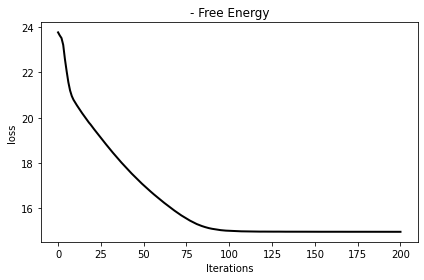

In [11]:
plot_loss(rpm, offset=0)

## Latent Distribution Embeddings of test images

In [12]:
rpm.forwarded_factors[1]

tensor([[[-5.0000e-01, -4.5217e-21,  1.7873e-23],
         [-4.5217e-21, -5.0000e-01,  2.2233e-21],
         [ 1.7873e-23,  2.2233e-21, -5.0000e-01]],

        [[-5.0000e-01, -4.5958e-13,  9.8502e-14],
         [-4.5958e-13, -5.0000e-01,  7.0425e-16],
         [ 9.8502e-14,  7.0425e-16, -5.0000e-01]]], device='cuda:0',
       grad_fn=<SubBackward0>)

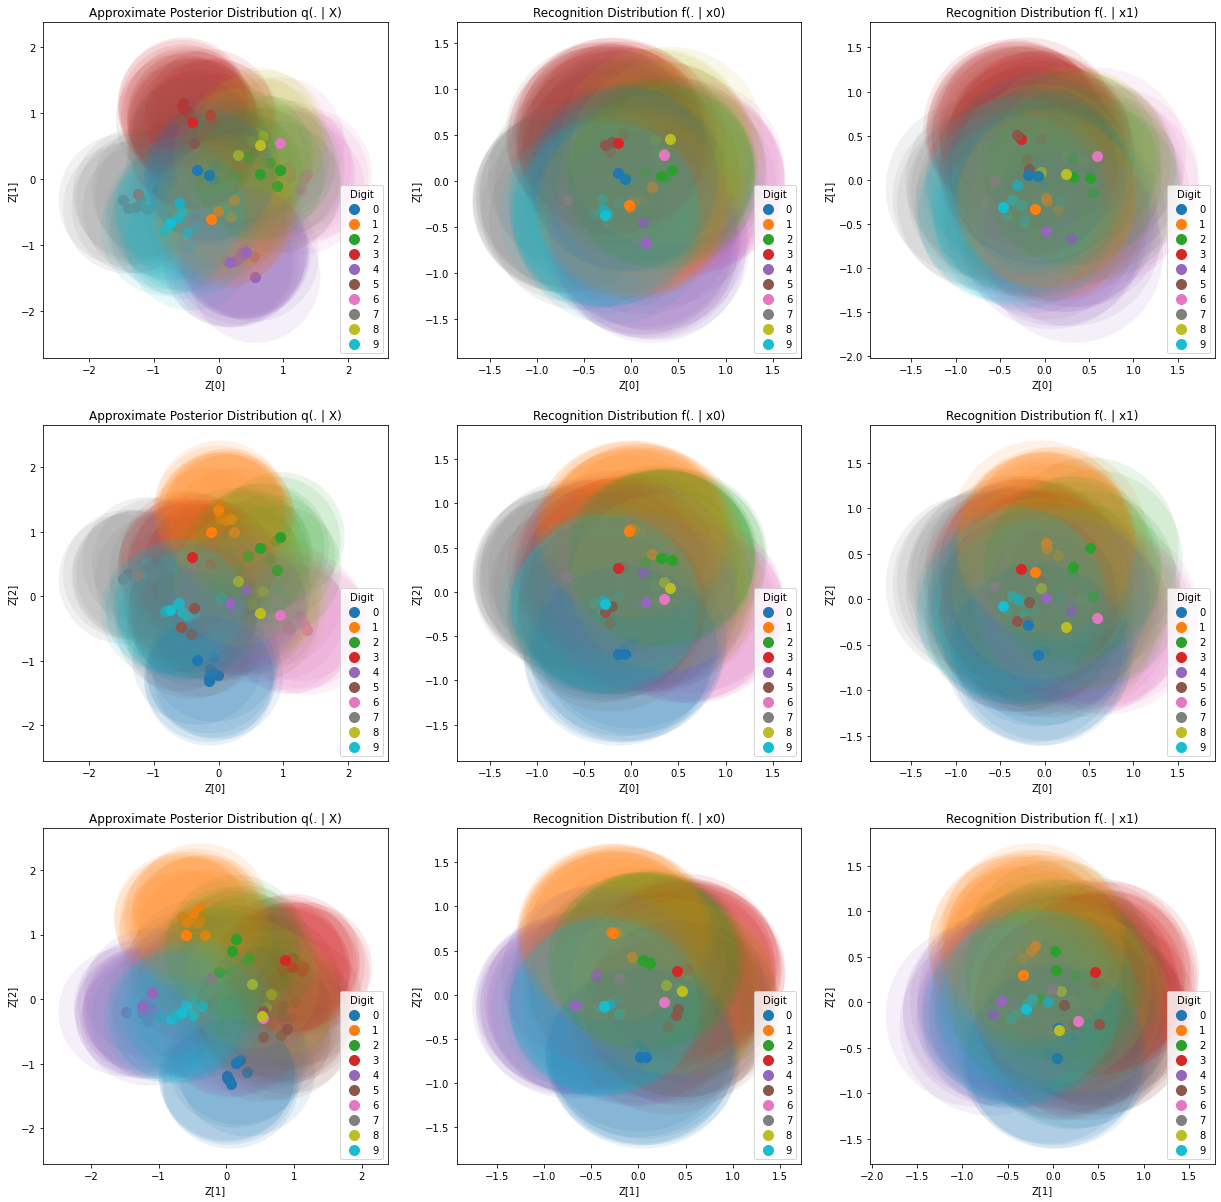

In [13]:
# Forward test data
import utils_process

dim_latent = rpm.dim_latent
heigh = int(dim_latent * (dim_latent - 1) / 2)
width = rpm.num_factors+1
plt.figure(figsize=(width * 7, heigh * 7))  

for J in range(-1, rpm.num_factors):

    #J = 0
    qdist, fdist = rpm.get_posteriors(obs_test)

    if J == -1:
        mean, vari = qdist.mean_covariance()
        title_str = 'Approximate Posterior Distribution q(. | X)'
    else:
        mean, vari = fdist.mean_covariance()
        mean = mean[J]
        vari = vari[J]
        title_str = 'Recognition Distribution f(. | x' + str(J) + ')'

    mean = mean.detach().clone().cpu().numpy()
    vari = vari.detach().clone().cpu().numpy()


    # Plot testing Data
    subset = 100
    xx = mean[:subset]
    zz = vari[:subset]
    yy = test_labels[:subset, J]
    cmap = plt.get_cmap("tab10")
    
    compt = 0
    for uu in range(dim_latent -1):
        for vv in range(uu+1, dim_latent):
            offset = width * compt 
            compt += 1
            
            ax = plt.subplot(dim_latent, width, J + 2 + offset)
            for ii in range(subset):
                y0 = int(yy[ii].numpy())
                x0 = xx[ii]
                z0 = zz[ii]
                plt.scatter(x0[uu], x0[vv], s=100, color=cmap(y0))
                utils_process.confidence_ellipse(x0[[uu, vv]], z0[[uu, vv]][:, [uu, vv]], ax, n_std=1.0, facecolor=cmap(y0), alpha=0.1)

            for ii in np.unique(yy):
                y0 = yy[np.where(yy == ii)]
                x0 = xx[np.where(yy == ii)]
                plt.scatter(x0[0, uu], x0[0, vv], s=100, label=str(int(ii)), color=cmap(int(y0[0].numpy())))
                
#            plt.xlim([-2, 2])
#            plt.ylim([-2, 2])
            plt.legend(title = 'Digit', loc= 'lower right')
            plt.xlabel('Z[' + str(uu) + ']')
            plt.ylabel('Z[' + str(vv) + ']')
            plt.title(title_str)

In [14]:
from flexible_multivariate_normal import FlexibleMultivariateNormal

qmean, qvar = qdist.mean_covariance()
fmean, fvar = fdist.mean_covariance()
n1, n2 = [xx.clone().detach() for xx in rpm.forwarded_prior]
pmean, pvar = FlexibleMultivariateNormal(n1, n2, init_cholesky=False, init_natural=True, store_suff_stat_mean=True).mean_covariance()
pmean = pmean.cpu().numpy()
pvar = pvar.cpu().numpy()



In [15]:
print(fvar[:, 0])

tensor([[[1.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 1.0000]],

        [[1.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 1.0000]]], device='cuda:0')


In [16]:
from flexible_multivariate_normal import vector_to_tril

tmp = vector_to_tril(rpm.precision_chol_vec_factors)
gain = torch.matmul(tmp, tmp.transpose(-1, -2))


print(gain)


tensor([[[ 3.5665e-23,  4.4006e-21, -1.6209e-23],
         [ 4.4006e-21,  5.4298e-19, -2.0013e-21],
         [-1.6209e-23, -2.0013e-21,  2.6599e-22]],

        [[ 6.3016e-11,  4.5269e-13, -1.4032e-13],
         [ 4.5269e-13,  3.2520e-15, -1.0080e-15],
         [-1.4032e-13, -1.0080e-15,  1.5759e-15]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)
